In [1]:
import urllib.parse
import urllib.request
import pandas as pd
import re
from tqdm.notebook import tqdm
import numpy as np
import pickle
import missingno as msno
import multiprocessing 
from multiprocessing import Manager, Pool
num_cores = int(multiprocessing.cpu_count()/8)
import random
import torch

In [2]:
# save data
#with open('mappingdict(KIN_ACC_ID).pickle','wb') as fw:
#    pickle.dump(mappingdict, fw)

# load data
with open('/home/geonwon/Code/Database/mappingdict(KIN_ACC_ID)HMM.pickle', 'rb') as fr:
    mappingdict = pickle.load(fr)

In [3]:
df1 = pd.read_csv('/home/geonwon/Code/Kinase_Substrate_Dataset',encoding = 'ISO-8859-1', header = 2, delimiter = '\t')#정답 데이터
df1

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
0,Dyrk2,DYRK2,Q5U4C9,mouse,NDEL1,83431.0,Q9ERR1,Ndel1,mouse,S336,1869686801,LGSsRPSsAPGMLPL,NaN,,X,NaN
1,Pak2,PAK2,Q64303,rat,MEK1,170851.0,Q01986,Map2k1,rat,S298,448284,RtPGRPLsSYGMDSR,Pkinase,,X,9128; 98195
2,Pak2,PAK2,Q64303,rat,PRKD1,85421.0,Q9WTQ1,Prkd1,rat,S203,449896,GVRRRRLsNVsLTGL,NaN,X,,NaN
3,Pak2,PAK2,Q64303,rat,prolactin,24683.0,P01237,Prl,rat,S206,451732,IRCLRRDsHKVDNYL,Hormone_1,,X,NaN
4,Pak2,PAK2,Q64303,rat,prolactin,5617.0,P01236,PRL,human,S207,451732,LHCLRRDsHKIDNYL,Hormone_1,,X,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21224,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
21225,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
21226,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN
21227,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESsPILTsFELVKVP,NaN,X,,13857


In [4]:
df1['KINASE'].

PKACA       1642
PKCA        1059
CK2A1        930
ERK2         843
CDK1         795
            ... 
YpkA           1
GRK7           1
COL4A3BP       1
DYRK4          1
ALDOB          1
Name: KINASE, Length: 442, dtype: int64

In [4]:
df2 = df1.dropna(subset = ['KIN_ACC_ID'])
df2

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
0,Dyrk2,DYRK2,Q5U4C9,mouse,NDEL1,83431.0,Q9ERR1,Ndel1,mouse,S336,1869686801,LGSsRPSsAPGMLPL,NaN,,X,NaN
1,Pak2,PAK2,Q64303,rat,MEK1,170851.0,Q01986,Map2k1,rat,S298,448284,RtPGRPLsSYGMDSR,Pkinase,,X,9128; 98195
2,Pak2,PAK2,Q64303,rat,PRKD1,85421.0,Q9WTQ1,Prkd1,rat,S203,449896,GVRRRRLsNVsLTGL,NaN,X,,NaN
3,Pak2,PAK2,Q64303,rat,prolactin,24683.0,P01237,Prl,rat,S206,451732,IRCLRRDsHKVDNYL,Hormone_1,,X,NaN
4,Pak2,PAK2,Q64303,rat,prolactin,5617.0,P01236,PRL,human,S207,451732,LHCLRRDsHKIDNYL,Hormone_1,,X,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21224,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
21225,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
21226,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN
21227,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESsPILTsFELVKVP,NaN,X,,13857


In [5]:
df2['KIN_ACC_ID'] = df2['KIN_ACC_ID'].apply(lambda x:x.replace("-2","")
                                            .replace("-3","")
                                            .replace("-8","")
                                            .replace("-10",""))


/tmp/ipykernel_3105739/3573221229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['KIN_ACC_ID'] = df2['KIN_ACC_ID'].apply(lambda x:x.replace("-2","")


In [6]:
df2

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
0,Dyrk2,DYRK2,Q5U4C9,mouse,NDEL1,83431.0,Q9ERR1,Ndel1,mouse,S336,1869686801,LGSsRPSsAPGMLPL,NaN,,X,NaN
1,Pak2,PAK2,Q64303,rat,MEK1,170851.0,Q01986,Map2k1,rat,S298,448284,RtPGRPLsSYGMDSR,Pkinase,,X,9128; 98195
2,Pak2,PAK2,Q64303,rat,PRKD1,85421.0,Q9WTQ1,Prkd1,rat,S203,449896,GVRRRRLsNVsLTGL,NaN,X,,NaN
3,Pak2,PAK2,Q64303,rat,prolactin,24683.0,P01237,Prl,rat,S206,451732,IRCLRRDsHKVDNYL,Hormone_1,,X,NaN
4,Pak2,PAK2,Q64303,rat,prolactin,5617.0,P01236,PRL,human,S207,451732,LHCLRRDsHKIDNYL,Hormone_1,,X,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21224,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
21225,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
21226,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN
21227,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESsPILTsFELVKVP,NaN,X,,13857


In [7]:
df2['KIN_ACC_ID'].isin(mappingdict.keys())

0        True
1        True
2        True
3        True
4        True
         ... 
21224    True
21225    True
21226    True
21227    True
21228    True
Name: KIN_ACC_ID, Length: 21226, dtype: bool

In [8]:
df2 = df2[df2['KIN_ACC_ID'].isin(mappingdict.keys())]
df2

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
0,Dyrk2,DYRK2,Q5U4C9,mouse,NDEL1,83431.0,Q9ERR1,Ndel1,mouse,S336,1869686801,LGSsRPSsAPGMLPL,NaN,,X,NaN
1,Pak2,PAK2,Q64303,rat,MEK1,170851.0,Q01986,Map2k1,rat,S298,448284,RtPGRPLsSYGMDSR,Pkinase,,X,9128; 98195
2,Pak2,PAK2,Q64303,rat,PRKD1,85421.0,Q9WTQ1,Prkd1,rat,S203,449896,GVRRRRLsNVsLTGL,NaN,X,,NaN
3,Pak2,PAK2,Q64303,rat,prolactin,24683.0,P01237,Prl,rat,S206,451732,IRCLRRDsHKVDNYL,Hormone_1,,X,NaN
4,Pak2,PAK2,Q64303,rat,prolactin,5617.0,P01236,PRL,human,S207,451732,LHCLRRDsHKIDNYL,Hormone_1,,X,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21224,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
21225,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
21226,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN
21227,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESsPILTsFELVKVP,NaN,X,,13857


<AxesSubplot:>

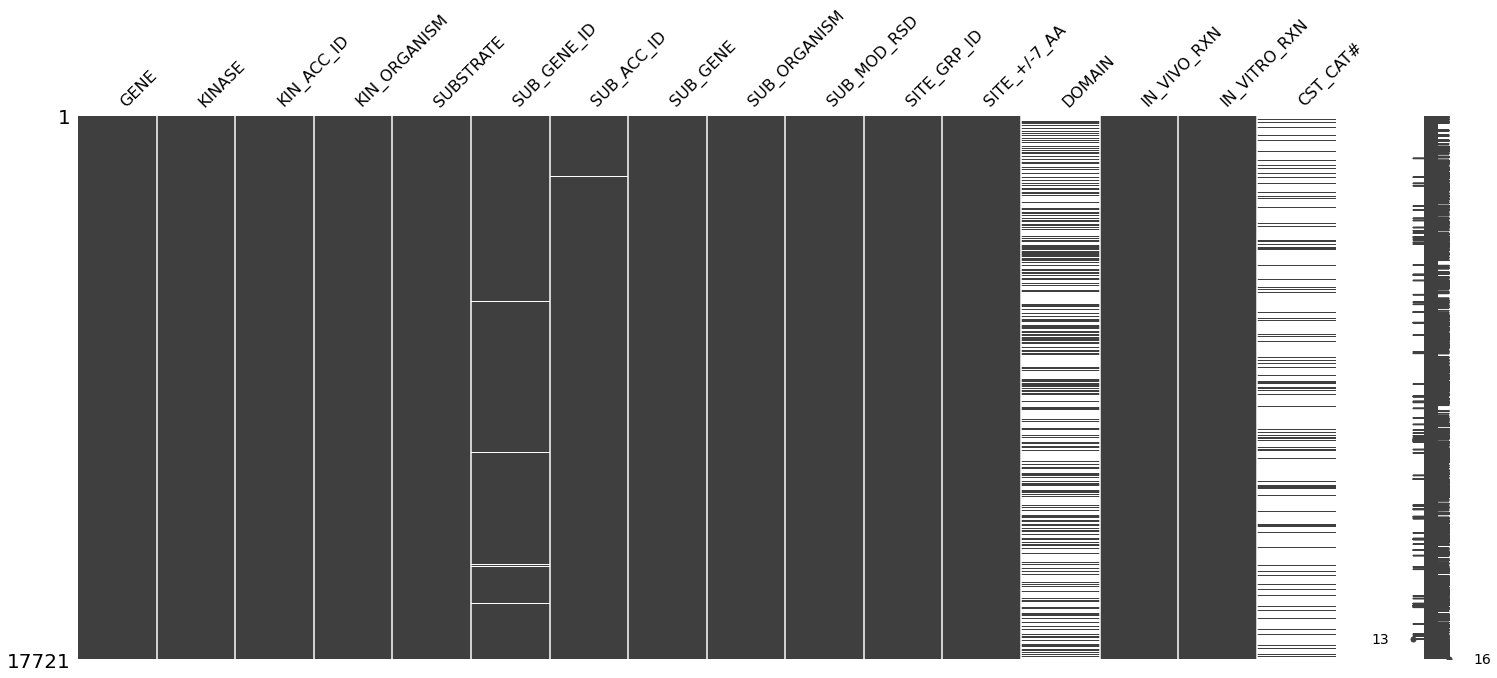

In [9]:
msno.matrix(df2)

In [10]:
df2['KINseq'] = 0

for n in range(17721):
    try:
        df2['KINseq'].iloc[n] = mappingdict[df2['KIN_ACC_ID'].iloc[n]]
        
    except KeyError:
        pass

/tmp/ipykernel_3105739/2287559522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['KINseq'] = 0
/tmp/ipykernel_3105739/2287559522.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['KINseq'].iloc[n] = mappingdict[df2['KIN_ACC_ID'].iloc[n]]


/tmp/ipykernel_3105739/3464608188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Length']=0
/tmp/ipykernel_3105739/3464608188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Length'] = df2['KINseq'].apply(lambda x:len(x))


336

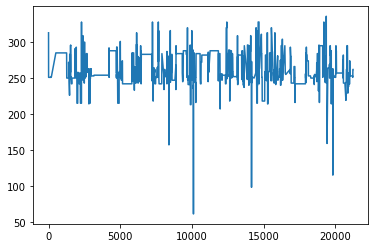

In [11]:

df2['Length']=0
df2['Length'] = df2['KINseq'].apply(lambda x:len(x))
df2['Length'].plot()
df2['Length'].max()

In [12]:
maxlencount = df2['Length'].max()

In [13]:
df2['KINseq'] = df2['KINseq'].apply(lambda x:x.ljust(maxlencount,'0'))

/tmp/ipykernel_3105739/914595691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['KINseq'] = df2['KINseq'].apply(lambda x:x.ljust(maxlencount,'0'))


In [14]:
df2['SITE_+/-7_AA'] = df2['SITE_+/-7_AA'].apply(lambda x:x.upper())

/tmp/ipykernel_3105739/1342199859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['SITE_+/-7_AA'] = df2['SITE_+/-7_AA'].apply(lambda x:x.upper())


In [15]:
df2['answer'] = 1

/tmp/ipykernel_3105739/1475070484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['answer'] = 1


In [16]:
df2['KINASE'].unique()

array(['DYRK2', 'PAK2', 'PKCD', 'Pim2', 'CK2A1', 'AurA', 'IKKB', 'DRAK2',
       'ITK', 'VRK1', 'CDK7', 'FGFR4', 'RIPK1', 'JNK1', 'DYRK4',
       'FAK iso2', 'EGFR', 'Fyn', 'AMPKA1', 'CDK12', 'CAMK4', 'AMPKA2',
       'NDR2', 'CK1E', 'MAPKAPK2', 'CAMK1A', 'Yes', 'Akt1', 'PKCB iso2',
       'EphB2', 'TBK1', 'HIPK3', 'TIE2', 'PRKD3', 'CDK8', 'Syk', 'STLK3',
       'HUNK', 'LYN', 'MYO3A', 'PKCI', 'IRAK1', 'CDKL5', 'PKACB', 'P38B',
       'HER4', 'STYK1', 'CDK2', 'Ret', 'RAF1', 'caMLCK', 'GSK3B', 'GRK6',
       'MEKK1', 'MARK3 iso3', 'CK1G2', 'Akt2', 'PKCT', 'FGR', 'CK1G1',
       'LKB1', 'MEK5', 'INSR', 'EphB1', 'LTK', 'Chk1', 'PKACA', 'GRK3',
       'ERK5', 'MARK1', 'ERK1', 'DAPK3', 'RIPK3', 'HPK1', 'AurC',
       'CAMKK1', 'Pim3', 'MEK1', 'Fes', 'CK1D', 'MEKK3', 'KSR2', 'CAMK2B',
       'PLK4', 'PKCB', 'BRSK1', 'MKK7', 'FRK', 'MPSK1', 'PAK1', 'MEKK2',
       'SGK1', 'HER2', 'MRCKA', 'OSR1', 'Src', 'PLK3', 'ICK', 'Arg',
       'GRK5', 'CDK3', 'WNK2', 'TrkB', 'ILK', 'TESK1', 'TIE1', 'PKCG

In [17]:
df2 = df2.drop_duplicates(['KINseq','SITE_+/-7_AA'])

In [18]:
df2

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#,KINseq,Length,answer
0,Dyrk2,DYRK2,Q5U4C9,mouse,NDEL1,83431.0,Q9ERR1,Ndel1,mouse,S336,1869686801,LGSSRPSSAPGMLPL,NaN,,X,NaN,YEVLKVIGKGSFGQVVKAYDHKVHQHVALKMVRNEKRFHRQAAEEI...,313,1
1,Pak2,PAK2,Q64303,rat,MEK1,170851.0,Q01986,Map2k1,rat,S298,448284,RTPGRPLSSYGMDSR,Pkinase,,X,9128; 98195,YTRYEKIGQGASGTVFTATDVALGQEVAIKQINLQKQPKKELIINE...,251,1
2,Pak2,PAK2,Q64303,rat,PRKD1,85421.0,Q9WTQ1,Prkd1,rat,S203,449896,GVRRRRLSNVSLTGL,NaN,X,,NaN,YTRYEKIGQGASGTVFTATDVALGQEVAIKQINLQKQPKKELIINE...,251,1
3,Pak2,PAK2,Q64303,rat,prolactin,24683.0,P01237,Prl,rat,S206,451732,IRCLRRDSHKVDNYL,Hormone_1,,X,NaN,YTRYEKIGQGASGTVFTATDVALGQEVAIKQINLQKQPKKELIINE...,251,1
4,Pak2,PAK2,Q64303,rat,prolactin,5617.0,P01236,PRL,human,S207,451732,LHCLRRDSHKIDNYL,Hormone_1,,X,NaN,YTRYEKIGQGASGTVFTATDVALGQEVAIKQINLQKQPKKELIINE...,251,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21224,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDTSSLTQSAPA,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
21225,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DTSSLTQSAPASPTN,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
21226,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFSVSLSNSH,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
21227,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESSPILTSFELVKVP,NaN,X,,13857,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1


In [18]:
# #비율맞춰서 랜덤False data 만들기 
# hash_data = pd.read_csv('/home/geonwon/Code/Calpha.txt', sep='\t')
# del hash_data['Unnamed: 0']
# hash_data.columns
# characters = hash_data.columns
# characters
# df2['singleSITE'] = df2['SITE_+/-7_AA'].apply(lambda x:list(x))
# valuestocount = []
# for j in range(17721):
#     for i in df2['singleSITE'].iloc[j]:
#         for n in characters:
#             if i == n:
#                 valuestocount.append(n)

# A = valuestocount.count('A')
# C = valuestocount.count('C')
# D = valuestocount.count('D')
# E = valuestocount.count('E')
# F = valuestocount.count('F')
# G = valuestocount.count('G')
# H = valuestocount.count('H')
# I = valuestocount.count('I')
# K = valuestocount.count('K')
# L = valuestocount.count('L')
# M = valuestocount.count('M')
# N = valuestocount.count('N')
# P = valuestocount.count('P')
# Q = valuestocount.count('Q')
# R = valuestocount.count('R')
# S = valuestocount.count('S')
# T = valuestocount.count('T')
# V = valuestocount.count('V')
# W = valuestocount.count('W')
# Y = valuestocount.count('Y')
# allcount = A + C + D + E + F + G+ H +I +K +L +M +N +P+ Q+ R+ S+ T+ V+ W +Y
# index = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
# dfop = pd.DataFrame({'aacount': [A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y]}, index = index)
# dfop['ratio'] = dfop['aacount'].apply(lambda x:x/allcount)

# percentage = dfop['ratio']
# total = 265815
# repeats = np.around(np.array(percentage) * total).astype(np.int64)  # [6, 3, 2]
# characters = np.repeat(index, repeats)
# userId   = ''.join([random.choice(characters) for _ in range(15)]) #aa의 frequency에 따라 출현율 차등
# dfTemp = df2.copy()
# dfTemp['answer'] = 0
# dfTemp['SITE_+/-7_AA'] = ''
# dfTemp['SITE_+/-7_AA'] = dfTemp['SITE_+/-7_AA'].apply(lambda x:x.join([random.choice(characters) for _ in range(15)]))
# df3 = pd.concat([df2,dfTemp],axis=0)

In [19]:
# #SITE_+/-7_AA중간 SYT로 맞추고 비율맞춰서 False data 만들기 
# #비율맞춰서 False data 만들기 
# hash_data = pd.read_csv('/home/geonwon/Code/Calpha.txt', sep='\t')
# del hash_data['Unnamed: 0']
# hash_data.columns
# characters = hash_data.columns
# characters
# df2['singleSITE'] = df2['SITE_+/-7_AA'].apply(lambda x:list(x))
# valuestocount = []
# for j in range(17721):
#     for i in df2['singleSITE'].iloc[j]:
#         for n in characters:
#             if i == n:
#                 valuestocount.append(n)

# A = valuestocount.count('A')
# C = valuestocount.count('C')
# D = valuestocount.count('D')
# E = valuestocount.count('E')
# F = valuestocount.count('F')
# G = valuestocount.count('G')
# H = valuestocount.count('H')
# I = valuestocount.count('I')
# K = valuestocount.count('K')
# L = valuestocount.count('L')
# M = valuestocount.count('M')
# N = valuestocount.count('N')
# P = valuestocount.count('P')
# Q = valuestocount.count('Q')
# R = valuestocount.count('R')
# S = valuestocount.count('S')
# T = valuestocount.count('T')
# V = valuestocount.count('V')
# W = valuestocount.count('W')
# Y = valuestocount.count('Y')
# allcount = A + C + D + E + F + G+ H +I +K +L +M +N +P+ Q+ R+ S+ T+ V+ W +Y
# index = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
# dfop = pd.DataFrame({'aacount': [A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y]}, index = index)
# dfop['ratio'] = dfop['aacount'].apply(lambda x:x/allcount)

# percentage = dfop['ratio']
# total = 265815
# repeats = np.around(np.array(percentage) * total).astype(np.int64)  # [6, 3, 2]
# characters = np.repeat(index, repeats)
# userId   = ''.join([random.choice(characters) for _ in range(7)])
# selectedcharacters = ['S', 'Y', 'T']
# userId += ''.join([random.choice(selectedcharacters) for _ in range(1)])
# userId += ''.join([random.choice(characters) for _ in range(7)])
# dfTemp = df2.copy()
# dfTemp['answer'] = 0
# dfTemp['SITE_+/-7_AA'] = ''
# dfTemp['SITE_+/-7_AA'] = dfTemp['SITE_+/-7_AA'].apply(lambda x:x.join([random.choice(characters) for _ in range(8)]))
# dfTemp['SITE_+/-7_AA'] = dfTemp['SITE_+/-7_AA'].apply(lambda x:x.join([random.choice(selectedcharacters)]))
# dfTemp['SITE_+/-7_AA'] = dfTemp['SITE_+/-7_AA'].apply(lambda x:x.join([random.choice(characters) for _ in range(8)]))
# df3 = pd.concat([df2,dfTemp],axis=0)

In [18]:
# #SYT ratio,substrate ratio exact match
# hash_data = pd.read_csv('/home/geonwon/Code/Calpha.txt', sep='\t')
# del hash_data['Unnamed: 0']
# hash_data.columns
# characters = hash_data.columns
# characters
# df2['singleSITE'] = df2['SITE_+/-7_AA'].apply(lambda x:list(x))
# valuestocount = []
# for j in range(17721):
#     for i in df2['singleSITE'].iloc[j]:
#         for n in characters:
#             if i == n:
#                 valuestocount.append(n)

# A = valuestocount.count('A')
# C = valuestocount.count('C')
# D = valuestocount.count('D')
# E = valuestocount.count('E')
# F = valuestocount.count('F')
# G = valuestocount.count('G')
# H = valuestocount.count('H')
# I = valuestocount.count('I')
# K = valuestocount.count('K')
# L = valuestocount.count('L')
# M = valuestocount.count('M')
# N = valuestocount.count('N')
# P = valuestocount.count('P')
# Q = valuestocount.count('Q')
# R = valuestocount.count('R')
# S = valuestocount.count('S')
# T = valuestocount.count('T')
# V = valuestocount.count('V')
# W = valuestocount.count('W')
# Y = valuestocount.count('Y')
# allcount = A + C + D + E + F + G+ H +I +K +L +M +N +P+ Q+ R+ S+ T+ V+ W +Y
# index = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
# dfop = pd.DataFrame({'aacount': [A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y]}, index = index)
# dfop['ratio'] = dfop['aacount'].apply(lambda x:x/allcount)

# percentage = dfop['ratio']
# total = 265815
# repeats = np.around(np.array(percentage) * total).astype(np.int64)  # [6, 3, 2]
# characters = np.repeat(index, repeats)
# #userId   = ''.join([random.choice(characters) for _ in range(7)])
# #selectedcharacters = ['S', 'Y', 'T']
# #userId += ''.join([random.choice(selectedcharacters) for _ in range(1)])
# #userId += ''.join([random.choice(characters) for _ in range(7)])
# #dfTemp = df2.copy()
# #dfTemp['answer'] = 0
# #dfTemp['SITE_+/-7_AA'] = ''

<ipython-input-18-4cdcd2247449>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['singleSITE'] = df2['SITE_+/-7_AA'].apply(lambda x:list(x))


In [19]:
#kin-sub로 false만들기
kinsub = pd.DataFrame({'kin':df2['KINseq'],'sub':df2['SITE_+/-7_AA']})
kinsub

,kin,sub
0,YEVLKVIGKGSFGQVVKAYDHKVHQHVALKMVRNEKRFHRQAAEEI...,LGSSRPSSAPGMLPL
1,YTRYEKIGQGASGTVFTATDVALGQEVAIKQINLQKQPKKELIINE...,RTPGRPLSSYGMDSR
2,YTRYEKIGQGASGTVFTATDVALGQEVAIKQINLQKQPKKELIINE...,GVRRRRLSNVSLTGL
3,YTRYEKIGQGASGTVFTATDVALGQEVAIKQINLQKQPKKELIINE...,IRCLRRDSHKVDNYL
4,YTRYEKIGQGASGTVFTATDVALGQEVAIKQINLQKQPKKELIINE...,LHCLRRDSHKIDNYL
...,...,...
21224,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,QRVLDTSSLTQSAPA
21225,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,DTSSLTQSAPASPTN
21226,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,LAQPINFSVSLSNSH
21227,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,ESSPILTSFELVKVP


In [20]:
kinsub['type'] = kinsub['sub'].apply(lambda x:x[7])

In [21]:
kinsub = kinsub[(kinsub['type'] != 'R')&(kinsub['type'] != 'I')]

In [22]:
kinsubST = kinsub[(kinsub['type'] == 'S')|(kinsub['type'] == 'T')]

In [23]:
kinsubY = kinsub[kinsub['type'] == 'Y']

In [18]:
##시도1 kin-sub 조합多 멀티프로세싱필요
# dffinal = pd.DataFrame(index=range(0,0), columns=['kin', 'sub'])

# for i in range(17721):
#     dftemp = pd.DataFrame({'kin':kinsub['kin'].iloc[i],'sub':df2['SITE_+/-7_AA']})
#     dftemp = dftemp[(dftemp.isin(kinsub)['kin'] == False)|(dftemp.isin(kinsub)['sub'] == False)]
#     dffinal = pd.concat([dffinal,dftemp])
#     return dffinal
# def parallelize_dataframe(df, func):
#     import numpy as np
#     df_split = np.array_split(df, num_cores)
#     pool = Pool(num_cores)
#     df1 = np.concatenate(pool.map(func, df_split), axis = 0)
#     pool.close()
#     pool.join()
#     return df1



KeyboardInterrupt: 

In [19]:
#시도2
# dffinal = pd.DataFrame(index=range(0,0), columns=['kin', 'sub'])
# def make_df(i):
#     dffinal = pd.DataFrame(index=range(0,0), columns=['kin', 'sub'])
#     dftemp = pd.DataFrame({'kin':kinsub['kin'].iloc[i],'sub':df2['SITE_+/-7_AA']})
#     dftemp = dftemp[(dftemp.isin(kinsub)['kin'] == False)|(dftemp.isin(kinsub)['sub'] == False)]
#     dffinal = pd.concat([dffinal,dftemp])
#     return dffinal

In [24]:
#시도3

kinST = list(set(kinsubST['kin']))
subST = list(set(kinsubST['sub']))
dffinalST = pd.DataFrame(index=range(0,0), columns=['kin', 'sub'])

def make_dfST(i):
    global dffinalST
    dftemp = pd.DataFrame({'kin':[kinST[i] for j in range(len(subST))],'sub':subST})
    dffinalST = pd.concat([dffinalST,dftemp])
    return dffinalST

for i in tqdm(range(len(kinST))):
    make_dfST(i)

  0%|          | 0/412 [00:00<?, ?it/s]

In [26]:
kinY = list(set(kinsubY['kin']))
subY = list(set(kinsubY['sub']))
dffinalY = pd.DataFrame(index=range(0,0), columns=['kin', 'sub'])
def make_dfY(i):
    global dffinalY
    dftemp = pd.DataFrame({'kin':[kinY[i] for j in range(len(subY))],'sub':subY})
    dffinalY = pd.concat([dffinalY,dftemp])
    return dffinalY

for i in tqdm(range(len(kinY))):
    make_dfY(i)

  0%|          | 0/167 [00:00<?, ?it/s]

In [27]:
dffinalST['type']=dffinalST['sub'].apply(lambda x:x[7])
dffinalY['type']=dffinalY['sub'].apply(lambda x:x[7])

In [28]:
dffinalST = pd.concat([dffinalST,kinsubST], join='outer')
dffinalST = dffinalST.drop_duplicates(keep = False)

In [29]:
dffinalY = pd.concat([dffinalY,kinsubY], join='outer')
dffinalY = dffinalY.drop_duplicates(keep = False)

In [12]:
# #dffinal[(dffinal.isin(kinsub)['kin'] == False)|(dffinal.isin(kinsub)['sub'] == False)]

# #example
# a = [['kin1'+'sub1'], ['kin1'+'sub2'], ['kin2'+'sub1']]
# b = [['kin1'+'sub1'], ['kin1'+'sub2'], ['kin1'+'sub3'], ['kin2'+'sub1']]

# a_sub_b = [x for x in b if x not in a]

# a_sub_b

[['kin1sub3']]

In [30]:
dffinal = pd.concat([dffinalST,dffinalY], join='outer')

In [31]:
dffinal

,kin,sub,type
0,GEVLGKGCFGQAIKVTHRETGEVMVMKELIRFDEETQRTFLKEVKV...,HGSGWAETPRTDRGG,T
1,GEVLGKGCFGQAIKVTHRETGEVMVMKELIRFDEETQRTFLKEVKV...,FLISPPASPPVGWKQ,S
2,GEVLGKGCFGQAIKVTHRETGEVMVMKELIRFDEETQRTFLKEVKV...,MANYTNLTQGAKEHE,T
3,GEVLGKGCFGQAIKVTHRETGEVMVMKELIRFDEETQRTFLKEVKV...,QRMLPSLSLTEDVKW,S
4,GEVLGKGCFGQAIKVTHRETGEVMVMKELIRFDEETQRTFLKEVKV...,IEDSREATHSSGFSG,T
...,...,...,...
1678,LLKELGNGQFGVVQLGQWKGQYDVAVKMIKEGAMSEDEFFQEAQTM...,GTPRRLLYCQRSLLD,Y
1679,LLKELGNGQFGVVQLGQWKGQYDVAVKMIKEGAMSEDEFFQEAQTM...,VEDPVYQYIVFEAGH,Y
1680,LLKELGNGQFGVVQLGQWKGQYDVAVKMIKEGAMSEDEFFQEAQTM...,_MGKAENYELYQVEL,Y
1681,LLKELGNGQFGVVQLGQWKGQYDVAVKMIKEGAMSEDEFFQEAQTM...,RKKSWEVYQGVCQKG,Y


In [3]:
#dffinal.to_csv("kin-subdffinal.csv")
dffinal = pd.read_csv("kin-subdffinal.csv")

In [4]:
hash_data = pd.read_csv('/home/geonwon/Code/Calpha.txt', sep='\t')

In [5]:
def make_matrix(df):
   # 해시값 불러오기
    hash_data = pd.read_csv('/home/geonwon/Code/Calpha.txt', sep='\t')
    hash_data.set_index(hash_data['Unnamed: 0'], inplace=True)
   # 불필요한 칼럼 정리
    del hash_data['Unnamed: 0']
    hash_data = np.exp(-1*hash_data)#ver2
    hash_data_list = []
    
    for amino in df['kin']:
        if amino in hash_data.columns:
            for target in df['sub']:
                if target == '_' or target == 'X' or target == 'U':
                    hash_data_list.append(0)
                else:
                    hash_data_list.append(hash_data[amino][target])   
        elif amino not in hash_data.columns:
            for target in df['sub']:
                hash_data_list.append(0)
   
    if len(df['sub'])==15:
        matrix = np.array(hash_data_list).reshape(1,336,15).astype('float16')
    return matrix

def make_df(df):
    df['matrix'] = df.apply(make_matrix, axis = 1)
    return df

def parallelize_dataframe(df, func):
    import numpy as np
    df_split = np.array_split(df, num_cores)
    pool = Pool(num_cores)
    df1 = np.concatenate(pool.map(func, df_split), axis = 0)
    pool.close()
    pool.join()
    return df1

In [6]:
df4 = parallelize_dataframe(dffinal, make_df)

Process ForkPoolWorker-14:
Process ForkPoolWorker-10:
Process ForkPoolWorker-12:
Process ForkPoolWorker-9:
Process ForkPoolWorker-13:


KeyboardInterrupt: 

Process ForkPoolWorker-7:
Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-2:
Process ForkPoolWorker-8:
Process ForkPoolWorker-16:
Process ForkPoolWorker-1:
Process ForkPoolWorker-15:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/geonwon/anaconda3/envs/base2/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/geonwon/anaconda3/envs/base2/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/geonwon/anaconda3/envs/base2/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (mo

In [1]:
#with open( "dfpsphmmkinsub.pickle", "wb" ) as file:
#    pickle.dump( df4, file)

with open( "dfpsphmmkinsub.pickle", "rb" ) as file:
    loaded_data = pickle.load(file)

#np.save('./dffasta+false', df5)
#df5 = np.load('./dffasta+false.npy',allow_pickle=True)



NameError: name 'pickle' is not defined